In [1]:

import re
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Stopwords and Lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\steja\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\steja\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\steja\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:

def clean_text(text):
    """Clean and preprocess text data"""
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", "", text)  # remove URLs
    text = re.sub(r"\S+@\S+", "", text)  # remove emails
    text = re.sub(r"[^a-z\s]", "", text)  # remove punctuation & numbers
    text = text.strip()
    
    tokens = [word for word in text.split() if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return " ".join(tokens)


In [8]:

class CustomNaiveBayes:
    """Custom implementation of Multinomial Naive Bayes"""
    
    def __init__(self):
        self.classes = None
        self.class_count = None
        self.feature_count = None
        self.class_priors = None
        self.feature_probs = None
    
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.class_count = len(self.classes)
        self.feature_count = X.shape[1]

        self.class_priors = np.zeros(self.class_count)
        for idx, c in enumerate(self.classes):
            self.class_priors[idx] = (np.sum(y == c) + 1) / (len(y) + self.class_count)

        self.feature_probs = np.zeros((self.class_count, self.feature_count))
        for idx, c in enumerate(self.classes):
            X_c = X[np.array(y) == c]
            self.feature_probs[idx] = (X_c.sum(axis=0).A1 + 1) / (X_c.sum() + self.feature_count)

    def predict(self, X):
        log_probs = []
        for i in range(X.shape[0]):
            x = X[i]
            log_prob_per_class = []
            for idx in range(self.class_count):
                log_prior = np.log(self.class_priors[idx])
                if hasattr(x, 'multiply'):
                    log_likelihood = np.sum(x.multiply(np.log(self.feature_probs[idx])))
                else:
                    log_likelihood = np.sum(x * np.log(self.feature_probs[idx]))
                log_prob_per_class.append(log_prior + log_likelihood)
            log_probs.append(np.argmax(log_prob_per_class))
        return np.array(log_probs)

    def predict_proba(self, X):
        probs = []
        for i in range(X.shape[0]):
            x = X[i]
            class_probs = []
            for idx in range(self.class_count):
                log_prior = np.log(self.class_priors[idx])
                if hasattr(x, 'multiply'):
                    log_likelihood = np.sum(x.multiply(np.log(self.feature_probs[idx])))
                else:
                    log_likelihood = np.sum(x * np.log(self.feature_probs[idx]))
                class_probs.append(log_prior + log_likelihood)
            exp_probs = np.exp(class_probs - np.max(class_probs))
            probs.append(exp_probs / exp_probs.sum())
        return np.array(probs)


In [9]:

def load_and_preprocess_data(dataset_path):
    """Load and preprocess the spam dataset"""
    try:
        df = pd.read_csv(dataset_path, compression='zip', encoding='latin-1')
    except:
        try:
            df = pd.read_csv(dataset_path, encoding='latin-1')
        except:
            raise ValueError("Error reading dataset. Check file path and format.")
    
    print("Dataset shape:", df.shape)
    print("Dataset columns:", df.columns.tolist())
    
    if 'message' in df.columns:
        df['text'] = df['message']
    elif 'text' not in df.columns:
        if len(df.columns) >= 2:
            df.columns = ['label', 'text'] + list(df.columns[2:])
        else:
            raise ValueError("Dataset doesn't have recognizable text column")
    
    if 'label' not in df.columns:
        df['label'] = df['text'].apply(lambda x: 'spam' if 'spam' in str(x).lower() else 'ham')
    
    df['label'] = df['label'].astype(str).str.lower()
    df['label'] = df['label'].map({'spam': 'spam', 'ham': 'ham', '1': 'spam', '0': 'ham'})
    df = df.dropna(subset=['label'])
    
    df['clean_text'] = df['text'].apply(clean_text)
    df = df[df['clean_text'].str.len() > 0]
    
    X = df['clean_text']
    y = df['label'].map({'ham': 0, 'spam': 1})
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    return X_train, X_test, y_train, y_test


In [10]:

def train_and_evaluate_model(X_train, X_test, y_train, y_test):
    vectorizer = CountVectorizer(max_features=5000)
    X_train_counts = vectorizer.fit_transform(X_train)
    X_test_counts = vectorizer.transform(X_test)
    
    tfidf = TfidfTransformer()
    X_train_tfidf = tfidf.fit_transform(X_train_counts)
    X_test_tfidf = tfidf.transform(X_test_counts)
    
    model = CustomNaiveBayes()
    model.fit(X_train_tfidf, y_train)
    
    y_pred = model.predict(X_test_tfidf)
    y_proba = model.predict_proba(X_test_tfidf)[:, 1]
    
    print("\nEVALUATION METRICS")
    print("="*50)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
    
    return model, vectorizer, tfidf


In [11]:

def predict_spam(text, model, vectorizer, tfidf):
    cleaned_text = clean_text(text)
    text_counts = vectorizer.transform([cleaned_text])
    text_tfidf = tfidf.transform(text_counts)
    prediction = model.predict(text_tfidf)[0]
    probability = model.predict_proba(text_tfidf)[0]
    
    result = "SPAM" if prediction == 1 else "HAM"
    confidence = probability[1] if prediction == 1 else probability[0]
    
    return result, confidence


Loading and preprocessing data...
Dataset shape: (517401, 2)
Dataset columns: ['file', 'message']

Training set size: 413920
Test set size: 103481

EVALUATION METRICS
Accuracy: 0.9984
Precision: 0.0435
Recall: 0.0280
F1 Score: 0.0341

Classification Report:
              precision    recall  f1-score   support

         Ham       1.00      1.00      1.00    103374
        Spam       0.04      0.03      0.03       107

    accuracy                           1.00    103481
   macro avg       0.52      0.51      0.52    103481
weighted avg       1.00      1.00      1.00    103481



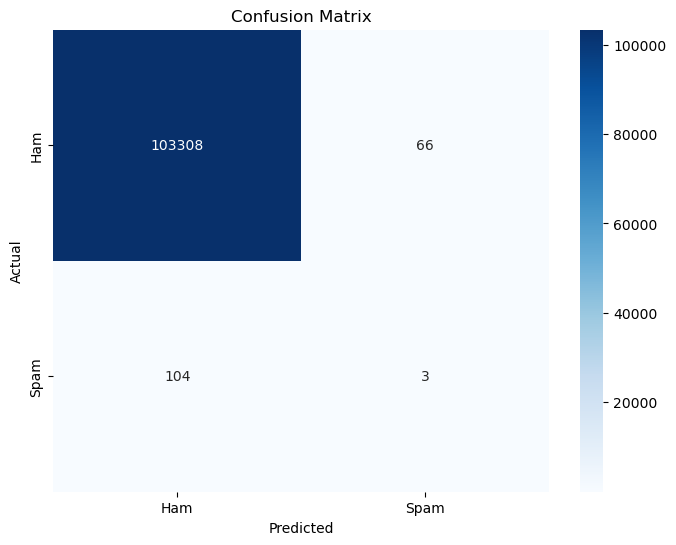

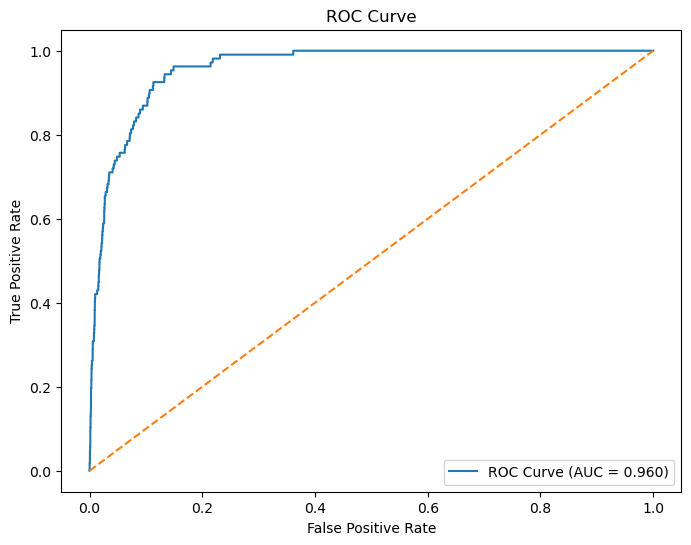

Model saved as 'spam_classifier_model.pkl'

Text: Congratulations! You've won $1000! Click here to c...
Prediction: HAM (Confidence: 0.999)

Text: Hi, how are you doing today? Would you like to mee...
Prediction: HAM (Confidence: 0.999)

Text: URGENT: Your account will be suspended. Verify now...
Prediction: HAM (Confidence: 0.998)

Text: Meeting scheduled for 3 PM tomorrow in conference ...
Prediction: HAM (Confidence: 1.000)


In [12]:

if __name__ == "__main__":
    dataset_path = r"C:\project1\archive.zip"  # Update path
    
    print("Loading and preprocessing data...")
    X_train, X_test, y_train, y_test = load_and_preprocess_data(dataset_path)
    
    print(f"\nTraining set size: {len(X_train)}")
    print(f"Test set size: {len(X_test)}")
    
    model, vectorizer, tfidf = train_and_evaluate_model(X_train, X_test, y_train, y_test)
    
    with open('spam_classifier_model.pkl', 'wb') as f:
        pickle.dump({'model': model, 'vectorizer': vectorizer, 'tfidf': tfidf}, f)
    
    print("Model saved as 'spam_classifier_model.pkl'")
    
    test_texts = [
        "Congratulations! You've won $1000! Click here to claim now!",
        "Hi, how are you doing today? Would you like to meet for coffee?",
        "URGENT: Your account will be suspended. Verify now!",
        "Meeting scheduled for 3 PM tomorrow in conference room."
    ]
    
    for text in test_texts:
        result, confidence = predict_spam(text, model, vectorizer, tfidf)
        print(f"\nText: {text[:50]}...")
        print(f"Prediction: {result} (Confidence: {confidence:.3f})")
